# Chicago Crimes Analysis

### 1) Create a Spark sesssion

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName("Chicago Crimes Analysis")\
  .enableHiveSupport()\
  .getOrCreate()

In [1]:
spark

### 2) Load data from a public dataset into a dataframe

In [2]:
# Read data from BigQuery
baseDF = spark.read \
  .format('bigquery') \
  .load('bigquery-public-data.chicago_crime.crime')

In [3]:
# Print schema
baseDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



In [4]:
display(baseDF.show(3,truncate=False))

+----------+-----------+-------------------+----------------+----+-------------------+------------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+-----------------------------+
|unique_key|case_number|date               |block           |iucr|primary_type       |description                   |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on         |latitude    |longitude    |location                     |
+----------+-----------+-------------------+----------------+----+-------------------+------------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+-----------------------------+
|8403453   |HT636387   |2011-12-16 07:10:00|002XX S CANAL ST|0265|CRIM SEXUAL ASSA

None

In [6]:
baseDF.createOrReplaceTempView("chicago_crimes_raw")

### 3) Transform the dataset

#### 3.1. Deduplicate

In [7]:
# 3.1.a. Read raw crimes into a dataframe
rawDF=spark.sql("select * from chicago_crimes_raw")

In [8]:
# 3.1.b. Dedupe the data
dedupedRawDF=rawDF.dropDuplicates()

In [9]:
dedupedRawDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



#### 3.2. Augment the data with temporal attributes

In [10]:
# 3.2.a. Create a UDF to return day of the week
from pyspark.sql.types import *
from pyspark.sql.functions import *

def getDayNameFromWeekdayNbr(weekday):
    if weekday == 0:
        return "Monday"
    if weekday == 1:
        return "Tuesday"
    if weekday == 2:
        return "Wednesday"
    if weekday == 3:
        return "Thursday"
    if weekday == 4:
        return "Friday"
    if weekday == 5:
        return "Saturday"
    if weekday == 6:
        return "Sunday"

udf_getDayNameFromWeekdayNbr = udf(getDayNameFromWeekdayNbr, StringType())

In [11]:
# 3.2.b. Add a column case_timestamp with case_dt_tm formatted to timestamp and create a temporary view on this
augmentedDF=spark.sql("select * from chicago_crimes_raw").withColumn("case_timestamp",to_timestamp("date","MM/dd/yyyy hh:mm:ss"))

In [12]:
augmentedDF.createOrReplaceTempView("crimes_raw_temp_with_timestamp")

In [13]:
augmentedDF.show(2)

+----------+-----------+-------------------+----------------+----+-------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+-------------------+
|unique_key|case_number|               date|           block|iucr|       primary_type|      description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|     case_timestamp|
+----------+-----------+-------------------+----------------+----+-------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+-------------------+
|   8403453|   HT636387|2011-12-16 07:10:00|002XX S CANAL ST|0265|CRIM SEXUAL ASSAULT|AG

In [14]:
augmentedDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- case_timestamp: timestamp (nullable = true)



In [15]:
# 3.2.c. Add some temporal attributes using Spark date features
curatedInitialDF = spark.sql("select *, month(case_timestamp) as case_month,dayofmonth(case_timestamp) as case_day_of_month, hour(case_timestamp) as case_hour, dayofweek(case_timestamp) as case_day_of_week_nbr from crimes_raw_temp_with_timestamp")

In [16]:
curatedInitialDF.show(2)

24/05/28 13:57:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----------+-------------------+----------------+----+-------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+-------------------+----------+-----------------+---------+--------------------+
|unique_key|case_number|               date|           block|iucr|       primary_type|      description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|     case_timestamp|case_month|case_day_of_month|case_hour|case_day_of_week_nbr|
+----------+-----------+-------------------+----------------+----+-------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+----------

In [17]:
# 3.2.d. Lets use the UDF we created to add the day of the week name
curatedDF=curatedInitialDF.withColumn("case_day_of_week_name",udf_getDayNameFromWeekdayNbr("case_day_of_week_nbr"))

In [18]:
curatedDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- case_timestamp: timestamp (nullable = true)
 |-- case_month: integer (nullable = true)
 |-- case_

In [20]:
curatedDF.show(2,truncate=False)

+----------+-----------+-------------------+----------------+----+-------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+-----------------------------+-------------------+----------+-----------------+---------+--------------------+---------------------+
|unique_key|case_number|date               |block           |iucr|primary_type       |description      |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on         |latitude    |longitude    |location                     |case_timestamp     |case_month|case_day_of_month|case_hour|case_day_of_week_nbr|case_day_of_week_name|
+----------+-----------+-------------------+----------------+----+-------------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

In [21]:
curatedDF.createOrReplaceTempView("chicago_crimes_temp_view")

### 4) Analyze crimes

#### 4.1. Crimes by year

In [22]:
crimesByYearDF=spark.sql("SELECT year,count(*) AS crime_count FROM chicago_crimes_temp_view GROUP BY year ORDER BY year;")
crimesByYearDF.show()

+----+-----------+
|year|crime_count|
+----+-----------+
|2001|     485912|
|2002|     486820|
|2003|     475989|
|2004|     469430|
|2005|     453779|
|2006|     448188|
|2007|     437089|
|2008|     427197|
|2009|     392841|
|2010|     370537|
|2011|     352008|
|2012|     336332|
|2013|     307561|
|2014|     275833|
|2015|     264840|
|2016|     269892|
|2017|     269172|
|2018|     269002|
|2019|     261468|
|2020|     212413|
+----+-----------+
only showing top 20 rows



In [23]:
# Convert results to a Pandas dataframe for visualization
crimesByYearPDF = crimesByYearDF.toPandas()

In [24]:
crimesByYearPDF

,year,crime_count
0,2001,485912
1,2002,486820
2,2003,475989
3,2004,469430
4,2005,453779
5,2006,448188
6,2007,437089
7,2008,427197
8,2009,392841
9,2010,370537


In [25]:
import matplotlib.pyplot as plt

<Axes: xlabel='year'>

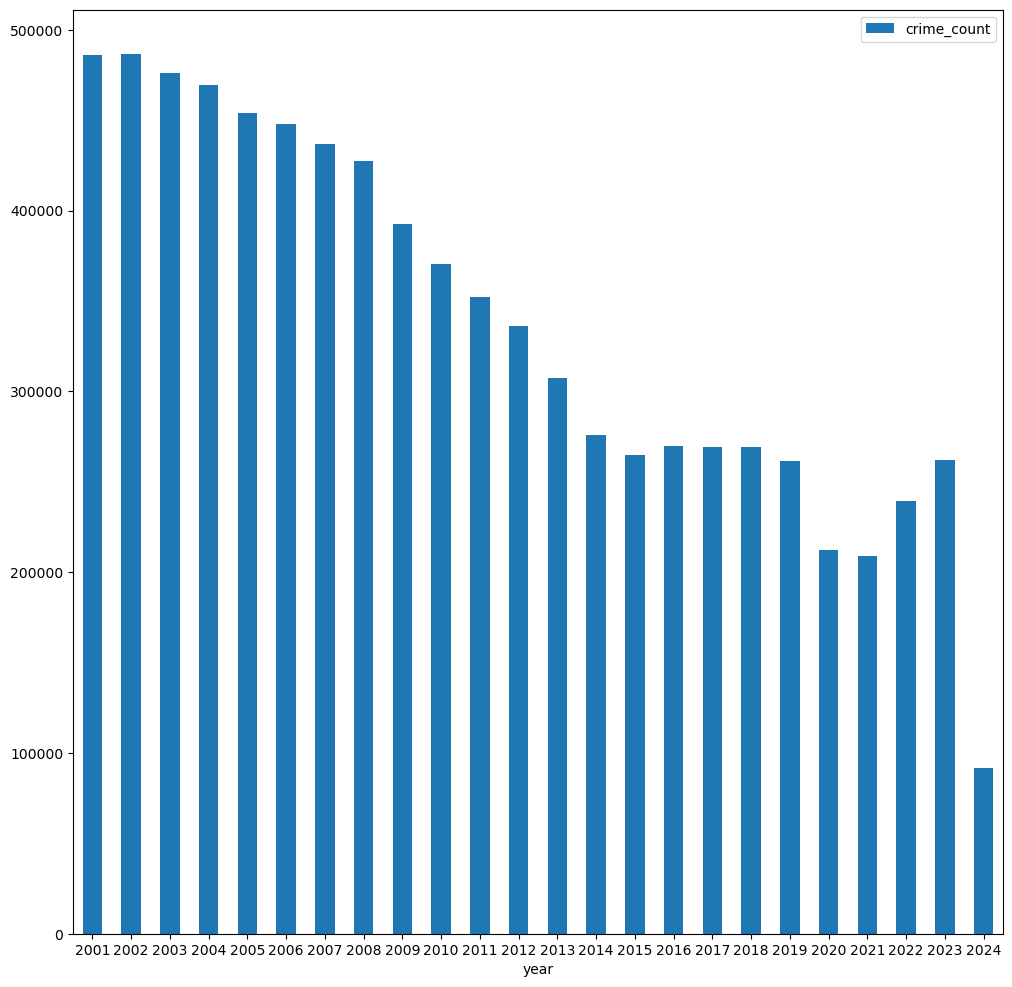

In [26]:
crimesByYearPDF.plot.bar(x='year', y='crime_count', rot=0,figsize=(12, 12))

#### 4.2. Crimes count by day

In [27]:

crimesByDayDF=spark.sql("SELECT case_day_of_week_name as day,count(*) AS crime_count FROM chicago_crimes_temp_view GROUP BY case_day_of_week_name ORDER BY case_day_of_week_name;")
crimesByDayDF.show()

+---------+-----------+
|      day|crime_count|
+---------+-----------+
|     NULL|    1156345|
|   Friday|    1160156|
| Saturday|    1148571|
|   Sunday|    1211254|
| Thursday|    1152842|
|  Tuesday|    1099145|
|Wednesday|    1140249|
+---------+-----------+



In [28]:
# Convert results to a Pandas dataframe for visualization
crimesByDayPDF = crimesByDayDF.toPandas()

<Axes: title={'center': 'Crimes by day of week'}, ylabel='crime_count'>

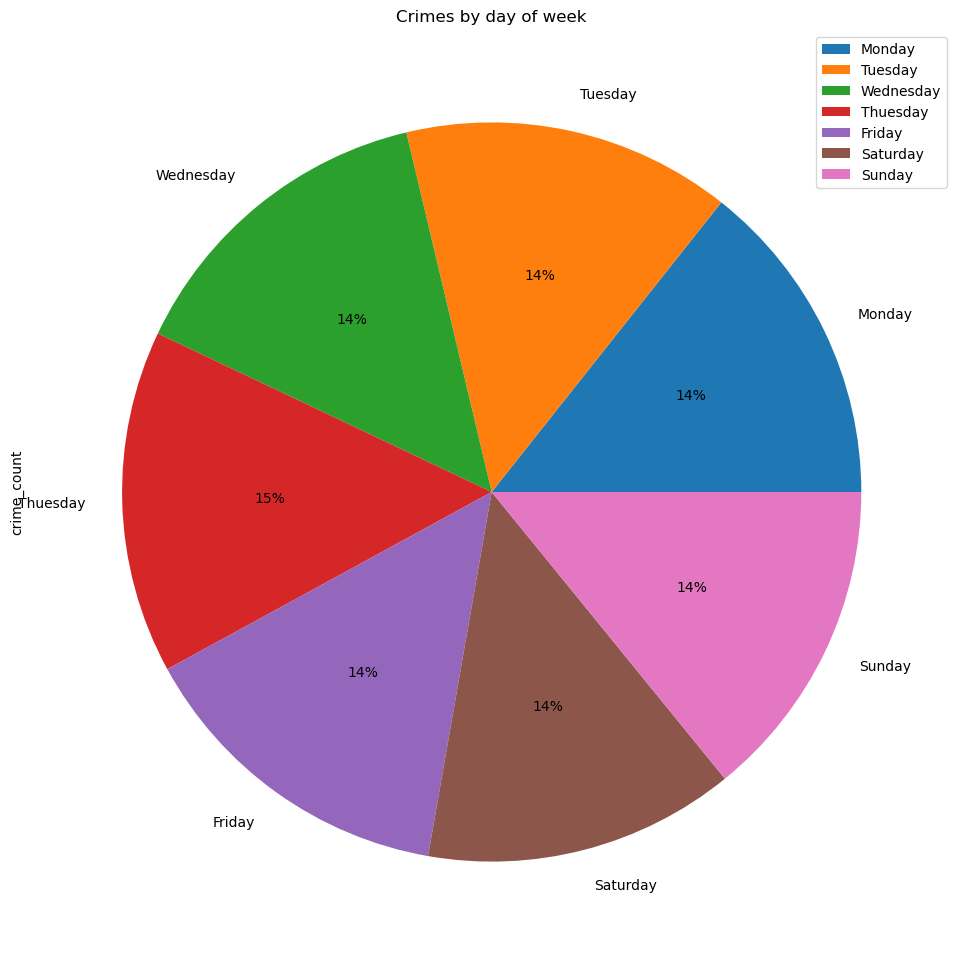

In [29]:
crimesByDayPDF.plot.pie(y='crime_count', x='day', figsize=(12,12),title='Crimes by day of week', labels = ['Monday','Tuesday','Wednesday','Thuesday','Friday','Saturday','Sunday'],autopct='%1.0f%%')